<a href="https://colab.research.google.com/github/joan-kii/machine-learning-coursera-Ng/blob/master/GarbageDet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificador de Basura**

En este Notebook vamos a crear un modelo de clasificación de basura como ejercicio de la [*lesson* 2 del curso de Deep Learning 2019 de fastai](https://course.fast.ai/videos/?lesson=2/).

Para ello utilizaremos el dataset [Garbage Classification de Kaggle](https://www.kaggle.com/asdasdasasdas/garbage-classification/).

Con los siguientes [*magic commands*](https://ipython.readthedocs.io/en/stable/interactive/magics.html/) nos aseguramos de recargar de forma automática cualquier modificación de las librerías o de los gráficos.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# **Cargamos las imágenes**

Desde *fastai* importamos el módulo *vision* para poder trabajar con imágenes. También importamos la función *error_rate* del módulo *metrics* que usaremos para analizar el rendimiento de nuestro modelo.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

Con la variable "bs" establecemos el tamaño de lote (*batch size*) que le pasaremos a la función "ImageDataBunch".

In [0]:
bs = 64

En este notebook trabajaremos con el dataset que está alojado en una cuenta de Google Drive. A continuación conectamos nuestro entorno de ejecución con nuestra cuenta de Google Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


En la variable "path" establecemos la ruta de acceso a nuestro dataset.

In [0]:
path = '/content/drive/My Drive/Garbage Dataset'

En esta celda cargamos las imágenes en la variable "fnames" y visualizamos la ruta de las 5 primeras.

In [6]:
fnames = get_image_files(path)
fnames[:5]

[PosixPath('/content/drive/My Drive/Garbage Dataset/paper297.jpg'),
 PosixPath('/content/drive/My Drive/Garbage Dataset/paper296.jpg'),
 PosixPath('/content/drive/My Drive/Garbage Dataset/paper293.jpg'),
 PosixPath('/content/drive/My Drive/Garbage Dataset/paper292.jpg'),
 PosixPath('/content/drive/My Drive/Garbage Dataset/paper298.jpg')]

Con la función "random.seed()" de la librería Numpy, nos aseguramos de pasarle al generador las imágenes en un orden aleatorio pero que será el mismo cada vez que lo carguemos.

Como podemos ver en el nombre de los archivos, cada imagen tiene su *label* en el propio nombre, acompañada de un número. Para obtener la etiqueta correspondiente a cada imagen en la variable "pat", utilizamos una RegEx (*[Regular Expression](https://regex101.com/r/EGCnXK/1/)*) "r", con la que obtenemos todo lo que no sean números "([^0-9/])" desde la última barra de la ruta "/" hasta la extensíon del archivo ".jpg" descartando los números "\d+".

In [0]:
np.random.seed(2)
pat = r'/([^0-9/]+)\d+.jpg$'

En la variable "data" cargamos el generador ["ImageDataBunch"](https://docs.fast.ai/vision.data.html/), una función creada específicamnete para gestionar imágenes.

In [0]:
data = ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

Con la función "*show_batch*" podemos realizar una visualización de nuestros datos.

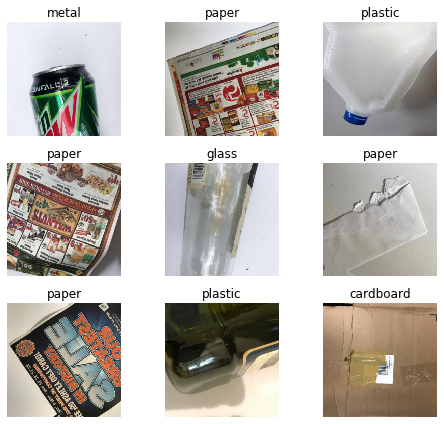

In [9]:
data.show_batch(rows=3, figsize=(7, 6))

Comprobamos cuántas clases tenemos y cuáles son.

In [10]:
print(data.classes)
len(data.classes), data.c

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


(6, 6)

# **Creamos y entrenamos nuestro modelo**

En la variable "learn" creamos nuestro modelo. En este caso utilizaremos una [*Convolutional Neural Network*](https://es.wikipedia.org/wiki/Redes_neuronales_convolucionales) (cnn), en concreto una ResNet50 de la librería de FastAi.

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.3MB/s]


Entrenamos nuestro modelo. Empezamos por comprobar como se comporta en 8 épocas.

In [12]:
learn.fit_one_cycle(8)

Podemos ver que nuestro modelo consigue una precisión de superior al 90% para las imágenes del dataset.

Guardamos esta primera configuración de nuestra red neuronal con el *tag* "stage-1".

In [0]:
learn.save('stage-1')

# **Reentrenamiento**

Una vez nuestro modelo termina la última época de entrenemiento, "cnn_learner" congela (*freeze*) los pesos (*weights*) obtenidos en cada capa para evitar perder, por accidente, el rendimeiento conseguido hasta el momento. Para poder reentrenar el modelo partiendo desde los últimos pesos, debemos descongelarlo (*unfreeze*).

In [0]:
learn.unfreeze()

Para conocer la tasa de aprendizaje de nuestro modelo (*learning rate*) utlilizamos la función "lr_find".

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Para visualizar el *learning rate* de nuestro modelo utilizamos la función "recorder.plot()".

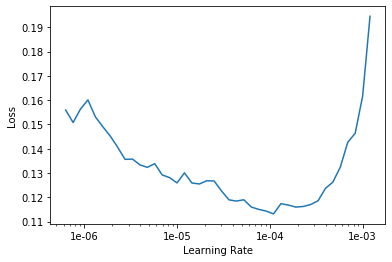

In [16]:
learn.recorder.plot()

Podemos observar que el *learning rate* desciende hasta 1e-4 aproximadamente. Ahora podemos reentrenar el modelo limitando el *learning rate* una banda entre 3e-5 y 3e-4.

In [17]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

Guardamos esta configuración en "stage-2".

In [0]:
learn.save('stage-2')

# **Interpretación**

Cargamos "stage-2".

In [18]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (2022 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
paper,paper,paper,paper,paper
Path: /content/drive/My Drive/Garbage Dataset;

Valid: LabelList (505 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
paper,glass,trash,glass,cardboard
Path: /content/drive/My Drive/Garbage Dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps

Para interpretar el rendimiento del modelo usamos la función "ClassificationInterpretation.from_learner()".

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

Para averiguar que clases confunde nuestro modelo, creamos una matriz de confusión con la función "plot_confusion_matrix()".

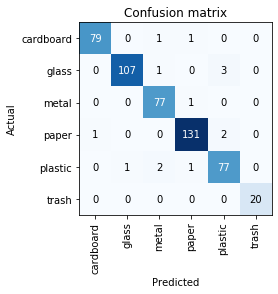

In [20]:
interp.plot_confusion_matrix()

Listamos los errores (*losses*) con la función most_confused().

In [21]:
interp.most_confused(min_val=2)

[('glass', 'plastic', 3), ('paper', 'plastic', 2), ('plastic', 'metal', 2)]

Aunque el rendimiento del modelo es mejorable, cumple con el objetivo de este ejercicio.

# **Predicción**

Para poner nuestro modelo en producción, lo exportamos con la función "export()", que creará un archivo en nuestro directorio. 

In [0]:
learn.export()

Para la realizar predicciones, conviene utilizar una CPU en lugar de una GPU.

In [0]:
defaults.device = torch.device('cpu')

Para poner a prueba el modelo, cargamos una imagen por cada categoría. Las imágenes que utilizaremos están descargadas de Google Imágenes. Son imágenes seleccionadas para que tengan cierta similitud con las empleadas en el dataset.

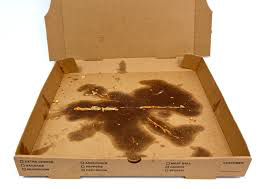

In [24]:
img = open_image('/content/drive/My Drive/Garbage Dataset/Predict/cardboard_predict.jpg'); img

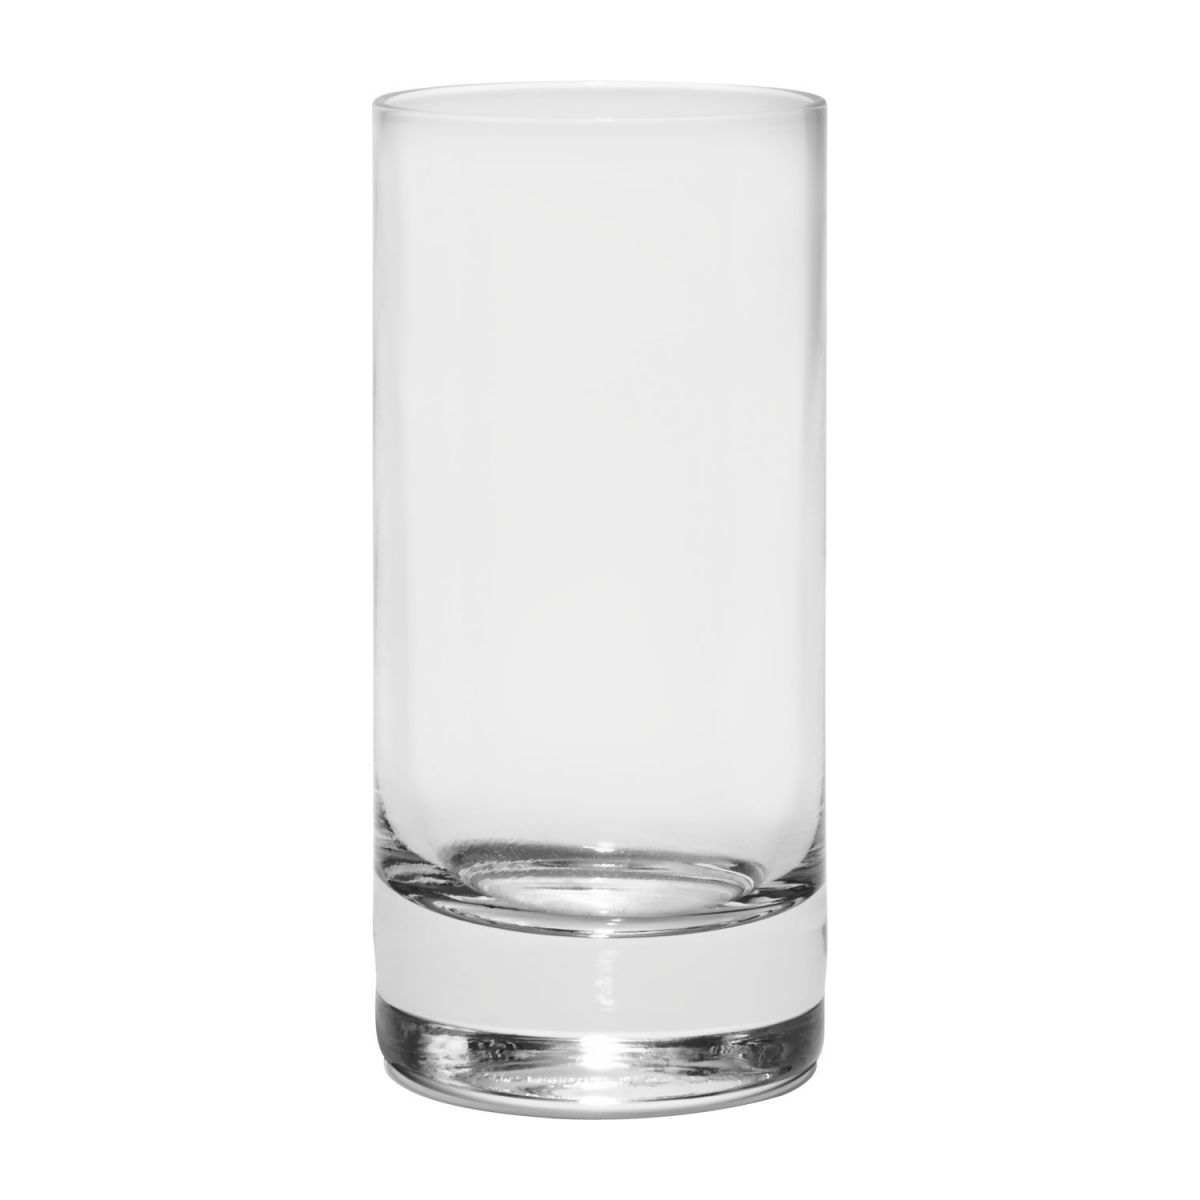

In [25]:
img1 = open_image('/content/drive/My Drive/Garbage Dataset/Predict/cristal_predict.jpg'); img1

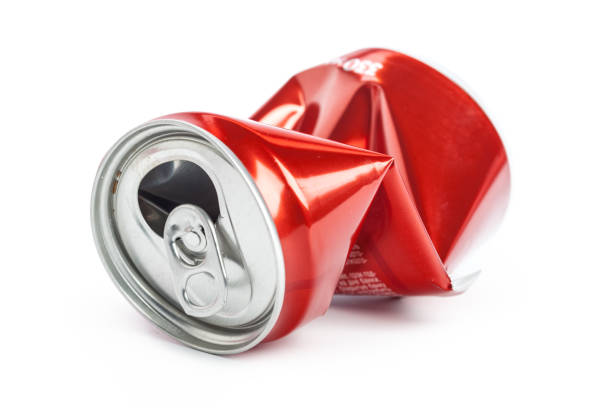

In [26]:
img2 = open_image('/content/drive/My Drive/Garbage Dataset/Predict/metal_predict.jpg'); img2

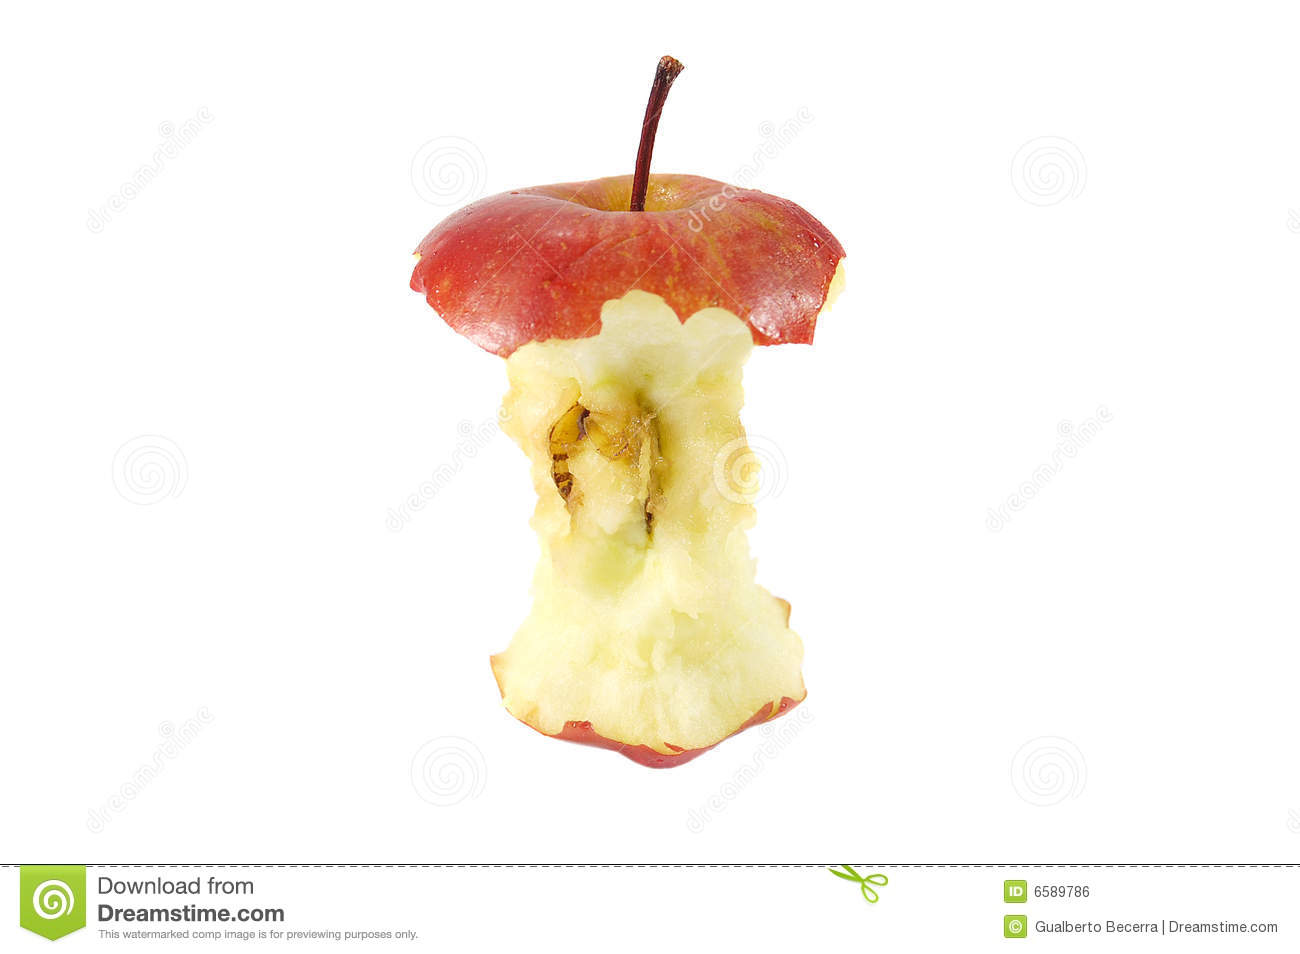

In [27]:
img3 = open_image('/content/drive/My Drive/Garbage Dataset/Predict/trash_predict.jpg'); img3

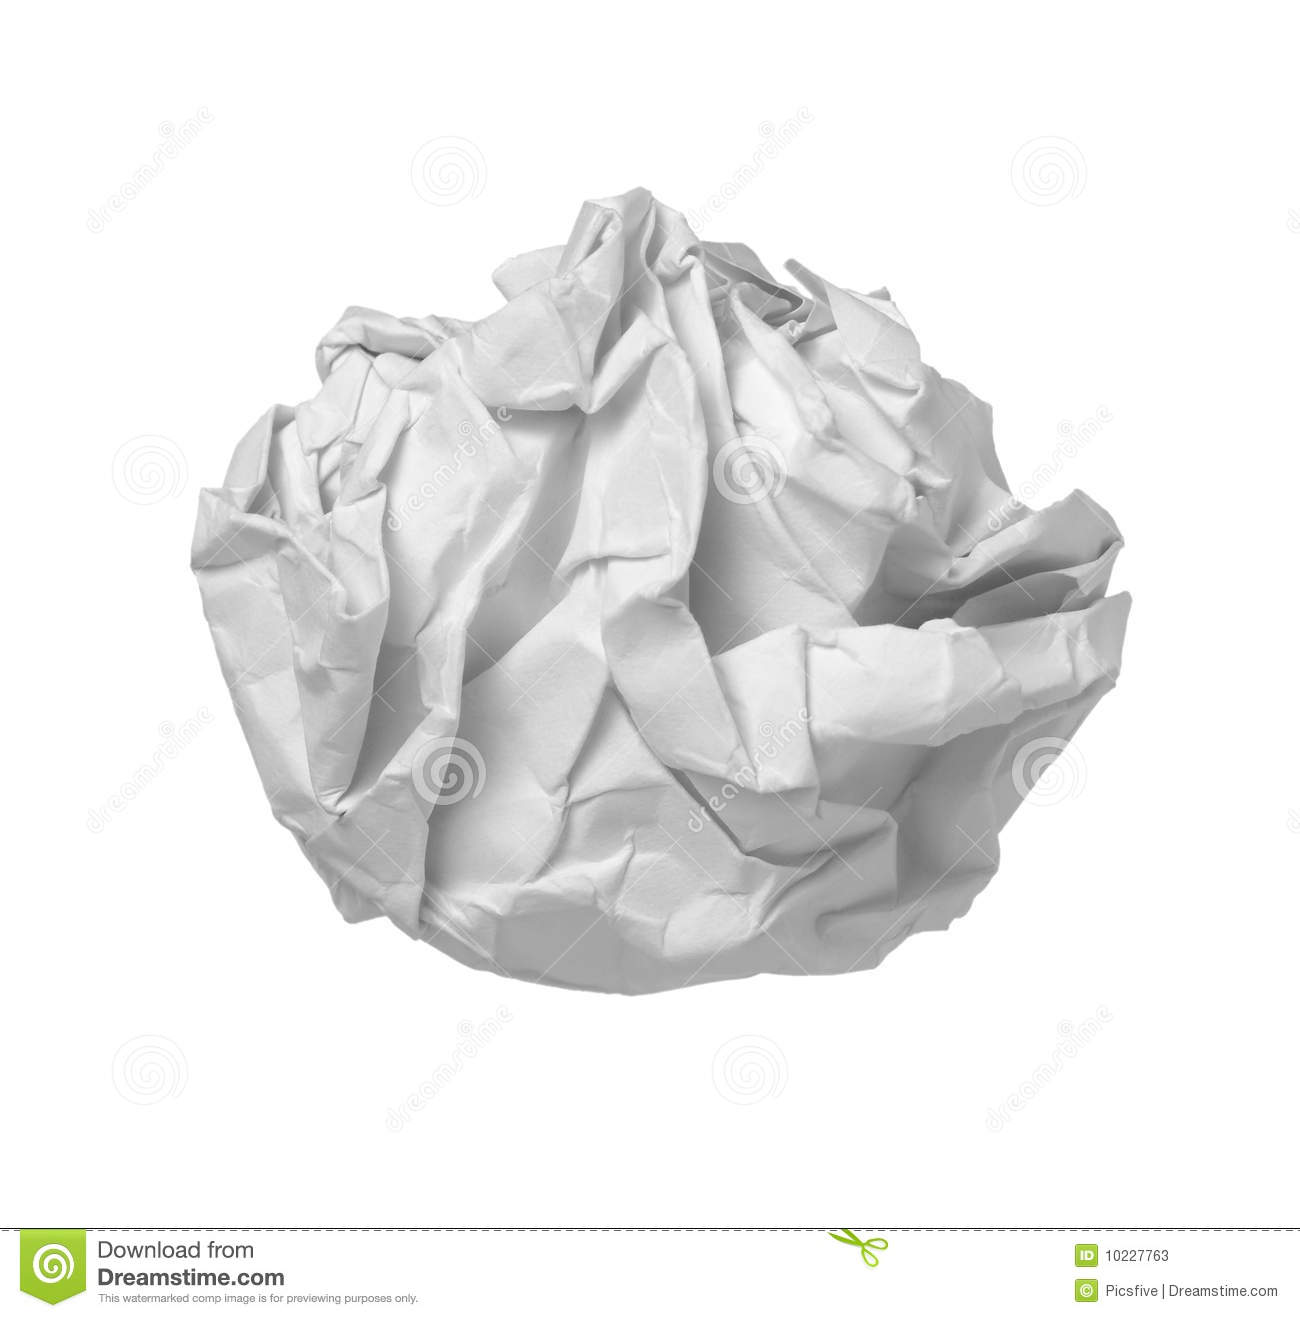

In [28]:
img4 = open_image('/content/drive/My Drive/Garbage Dataset/Predict/paper_predict.jpg'); img4

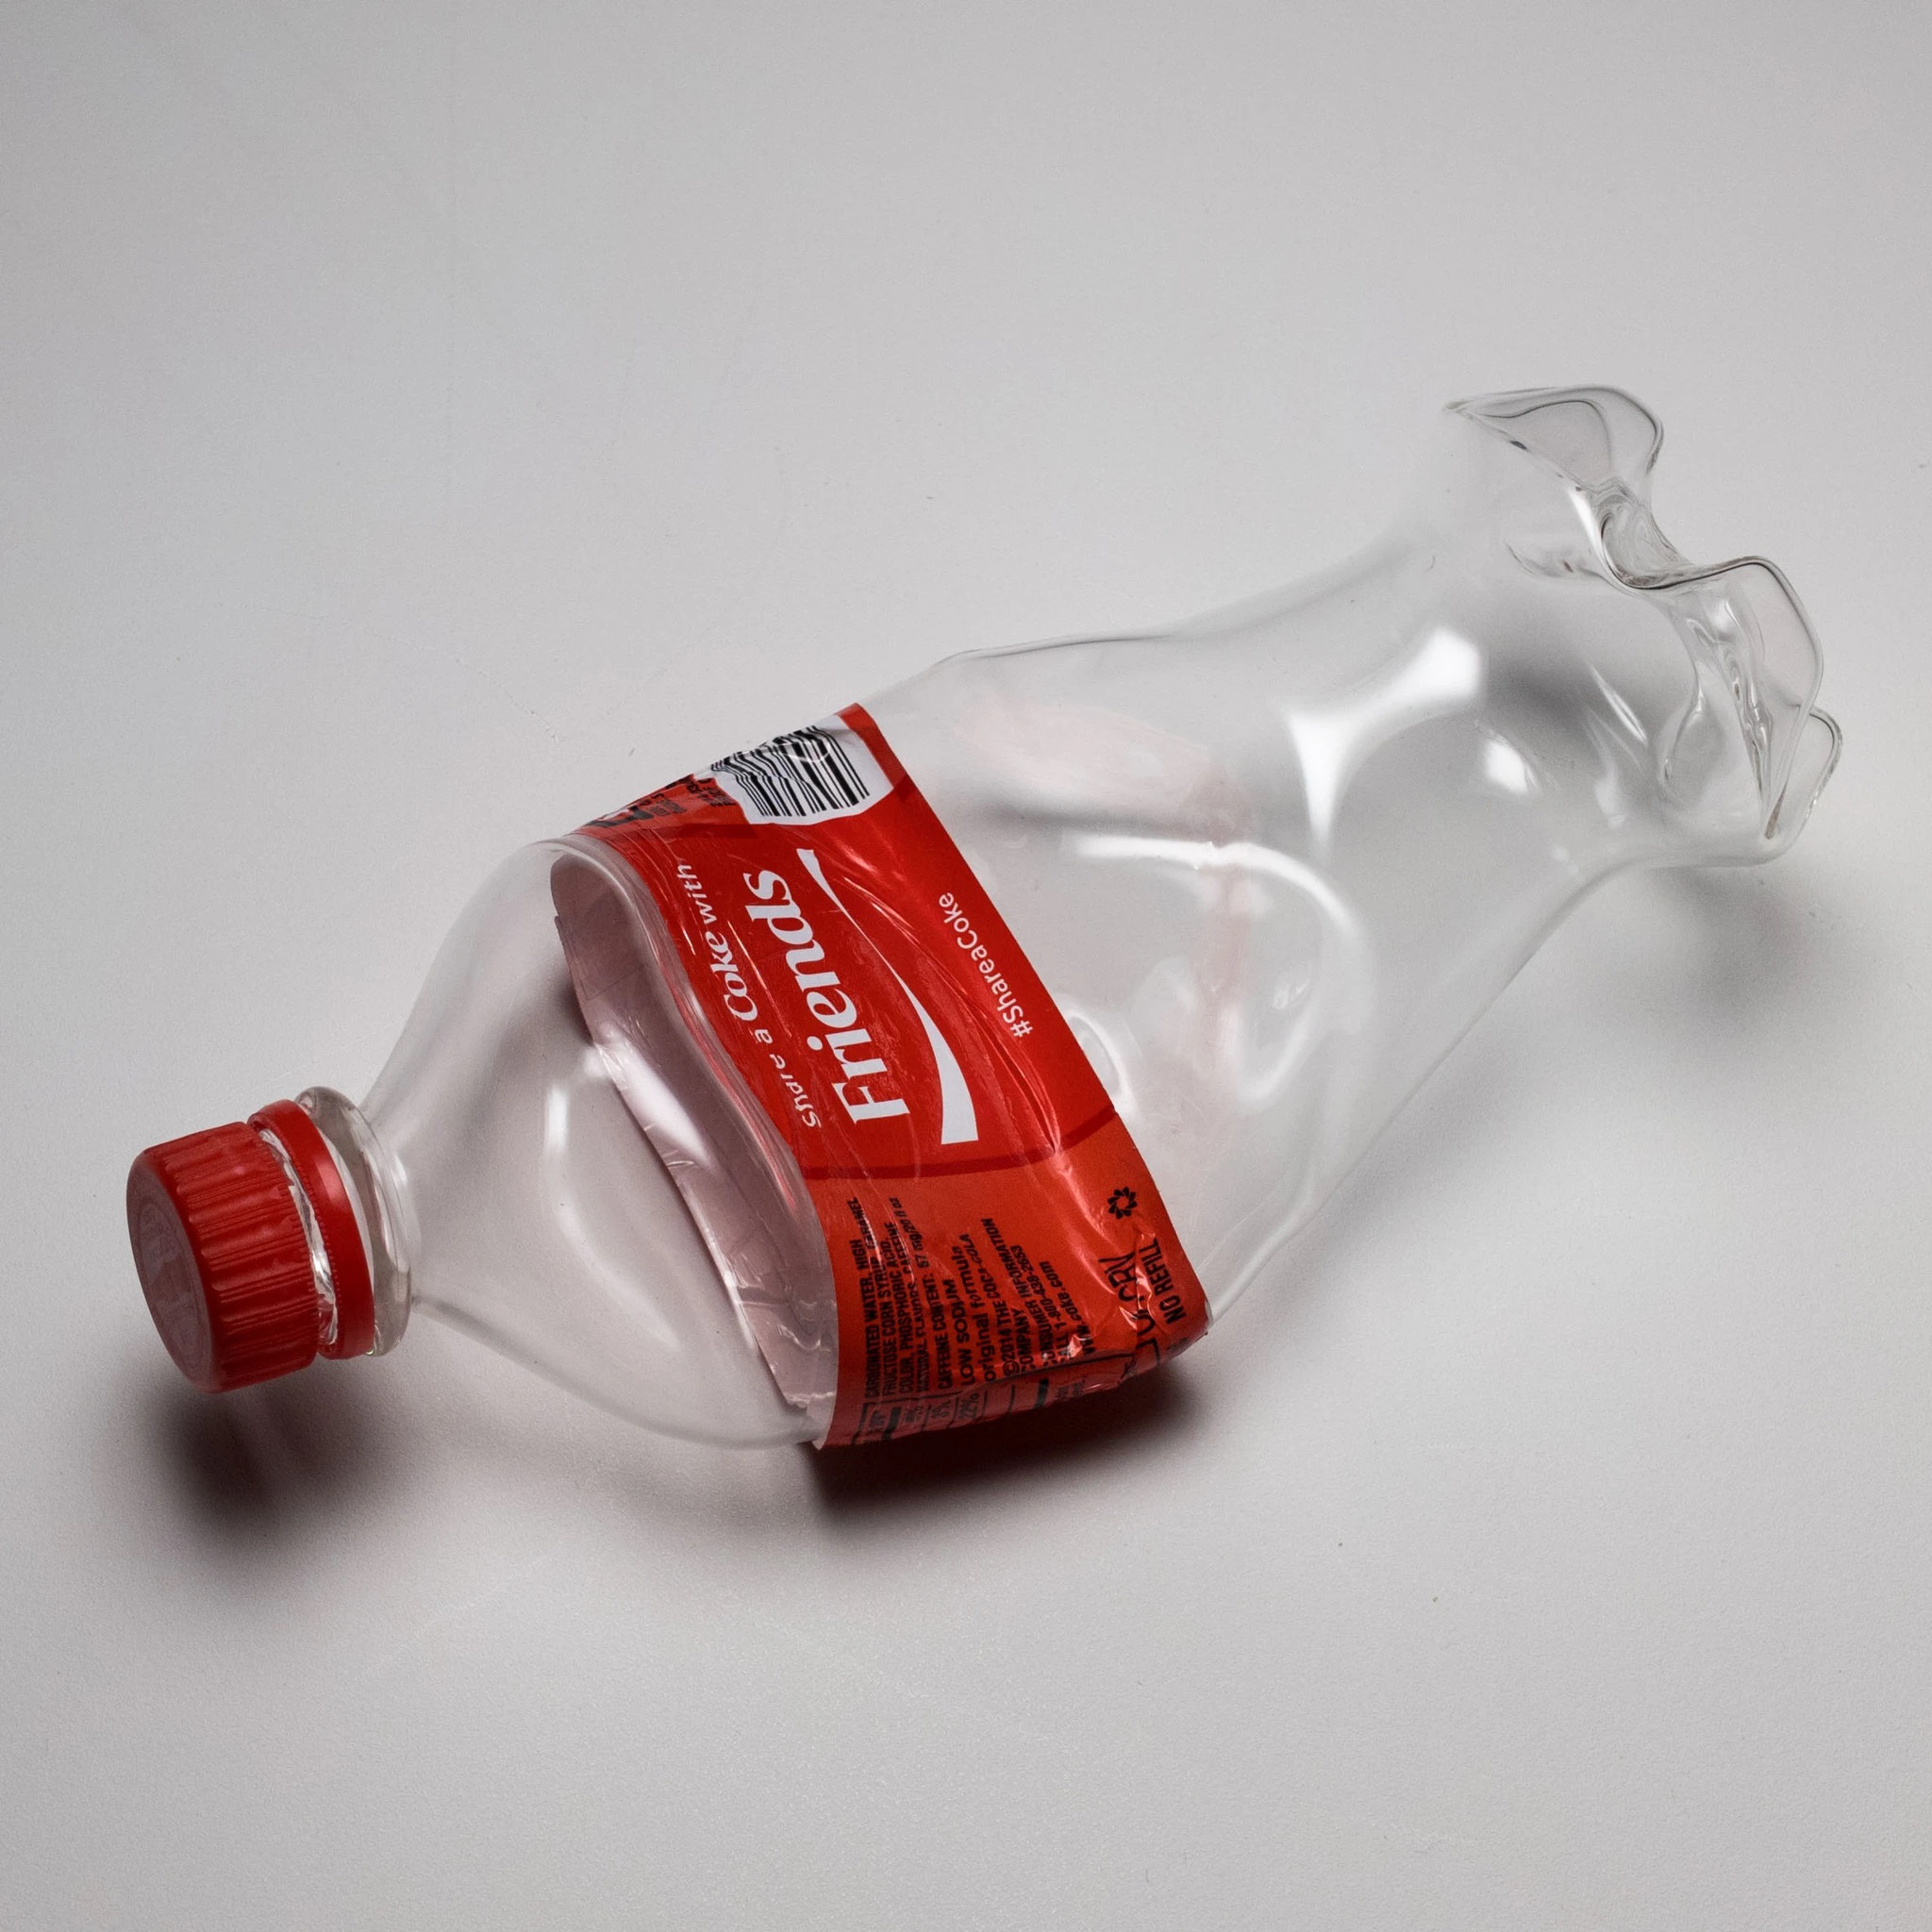

In [29]:
img5 = open_image('/content/drive/My Drive/Garbage Dataset/Predict/plastic_predict.jpg'); img5

Cargamos el modelo que hemos creado en nuestro directorio.

In [0]:
learn = load_learner(path)

Le pasamos cada imagen para que haga su predicción con la función "predict()".

In [31]:
pred_class,pred_idx,outputs = learn.predict(img); pred_class

Category cardboard

In [32]:
pred_class,pred_idx,outputs = learn.predict(img1); pred_class

Category glass

In [33]:
pred_class,pred_idx,outputs = learn.predict(img2); pred_class

Category metal

In [34]:
pred_class,pred_idx,outputs = learn.predict(img3); pred_class

Category trash

In [35]:
pred_class,pred_idx,outputs = learn.predict(img4); pred_class

Category paper

In [36]:
pred_class,pred_idx,outputs = learn.predict(img5); pred_class

Category plastic

Obtenemos un 100% de acierto.

# **Conclusión**

Para conseguir que nuestro modelo generalice bien, deberíamos realizar cietas mejoras. La primera sería aumentar nuestro dataset con más imágenes, pero sobretodo con unas imágenes más heterogéneas. El objetivo sería enriquecer nuestro dataset con imágenes en distintos contextos.

Si embargo, el modelo cumple con lo esperado para el objeto de este ejercicio. Por lo que dejamos las mejoras para futuras revisiones.